# Bahdanau注意力
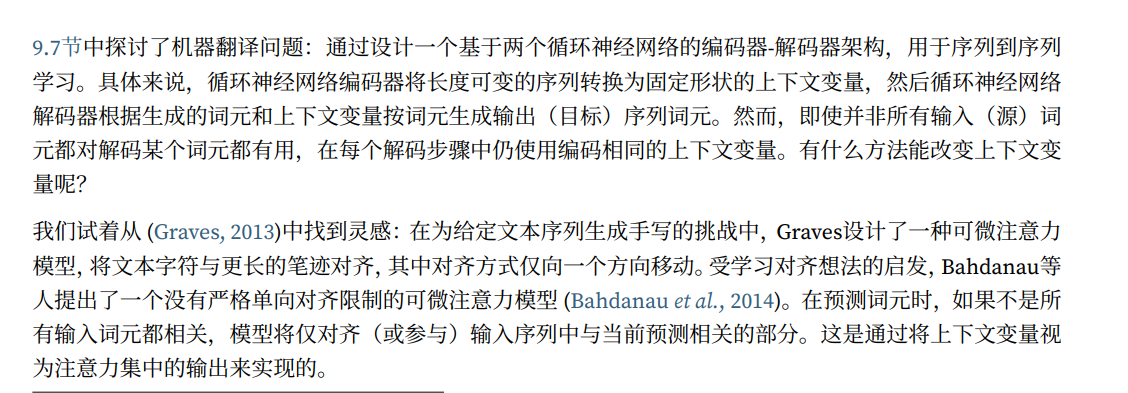

+ **Seq2Seq模型的decoder接受的仅仅只是encoder传过来的最后一个时间步上的隐状态，无法看到前面时间步的输入内容（虽然传过去的内容可能包含了部分前面时间步内容）**

+ **使用attention机制的动机：我们希望在执行类似机器翻译的任务时，可以关注源语言和目标语言对应位置的内容，因为在大部分情况下不同位置的词语对应不同类别的翻译**

## 1. 模型
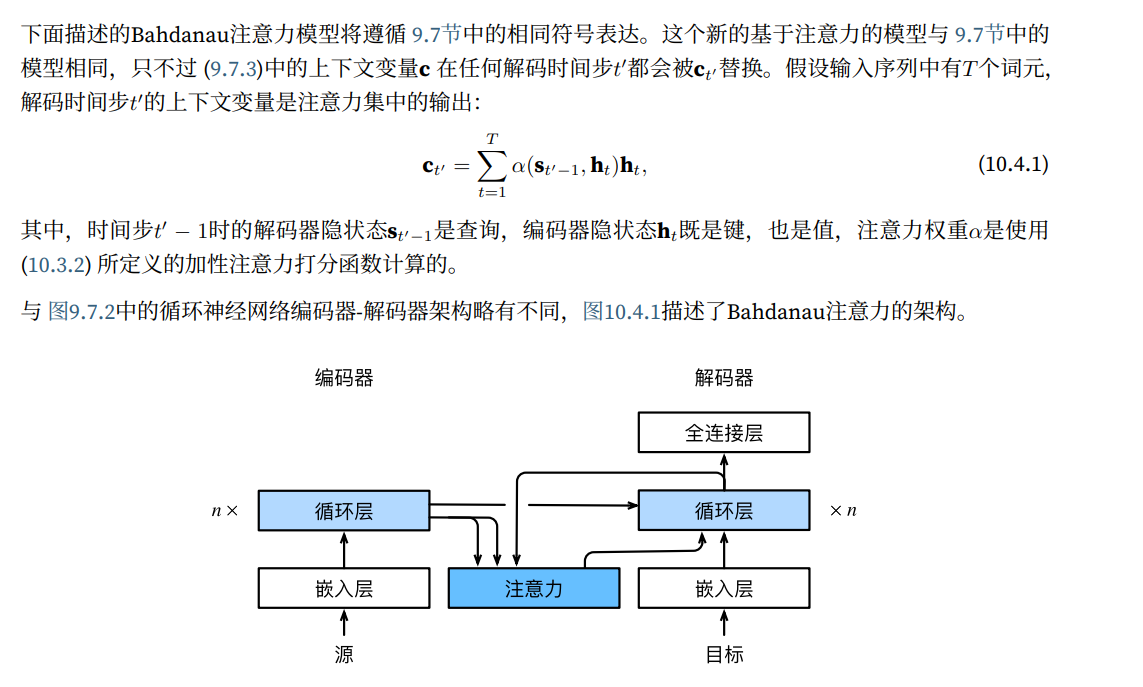
+ 结构特点 **根据预测值的不同，可能对应的encoder时间步的隐状态也不同，需要的是前面对应位置的隐状态，而不是最后面一个，将该隐状态与embedding向量再并起来传入decoder**
+ encoder对每次词的输出作为attention的key和value
+ decoder对上一个词的输出作为query
+ attention的输出和下一个词的embedding向量合并进入decoder rnn模块

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

## 2. 定义注意力解码器
下⾯看看如何定义Bahdanau注意⼒，实现循环神经⽹络编码器-解码器。其实，我们只需重新定义解码器即
可。为了更⽅便地显⽰学习的注意⼒权重，以下AttentionDecoder类定义了带有注意⼒机制解码器的基本接
⼝。

In [2]:
#@save
class AttentionDecoder(d2l.Decoder):
    # 带有注意力机制解码器的基本接口
    def __init__(self, **kwargs):
        super(AttentionDecoder, self).__init__(**kwargs)
    
    @property
    def attention_weights(self):
        raise NotImplementedError

接下来，让我们在接下来的Seq2SeqAttentionDecoder类中实现带有Bahdanau注意⼒的循环神经⽹络解码器。
⾸先，初始化解码器的状态，需要下⾯的输⼊：
+ 1. 编码器在所有时间步的最终层隐状态，将作为注意⼒的键和值；
+ 2. 上⼀时间步的编码器全层隐状态，将作为初始化解码器的隐状态；
+ 3. 编码器有效⻓度（排除在注意⼒池中填充词元）。


在每个解码时间步骤中，解码器上⼀个时间步的最终层隐状态将⽤作查询。因此，注意⼒输出和输⼊嵌⼊都连结为循环神经⽹络解码器的输⼊。


In [3]:
class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                dropout=0, **kwargs):
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs)
        # 这里attention层的的query，key， values的长度都是num_hiddens，即encoder输出的隐状态层的大小
        self.attention = d2l.AdditiveAttention(
                num_hiddens, num_hiddens, num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(
                embed_size + num_hiddens, num_hiddens, num_layers,
                dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)
    
    def init_state(self, enc_outputs, enc_valid_lens, *args):
        # outputs的形状为(batch_size，num_steps，num_hiddens).
        # hidden_state的形状为(num_layers，batch_size，num_hiddens)
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

    
    def forward(self, X, state):
        # enc_outputs的形状为(batch_size,num_steps,num_hiddens).
        # hidden_state的形状为(num_layers,batch_size,
        # num_hiddens)
        enc_outputs, hidden_state, enc_valid_lens = state
        # 输出X的形状为(num_steps,batch_size,embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            # query的形状为(batch_size,1,num_hiddens)
            # hidden_state就上一个时间步rnn隐藏层的输出
            # 同时这里拓展维度，新加的维度为num_queries=1
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            # context的形状为(batch_size,1,num_hiddens)
            # enc_valid_len表示在原始ju'zi'zhong
            context = self.attention(
                query, enc_outputs, enc_outputs, enc_valid_lens)
                # 在特征维度上连结
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            # 将x变形为(1,batch_size,embed_size+num_hiddens)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        # 全连接层变换后，outputs的形状为
        # (num_steps,batch_size,vocab_size)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state,
                                            enc_valid_lens]
    
    @property
    def attention_weights(self):
        return self._attention_weights

接下来，使⽤包含7个时间步的4个序列输⼊的⼩批量测试Bahdanau注意⼒解码器。


In [4]:
encoder = d2l.Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                            num_layers=2)
encoder.eval()
decoder = Seq2SeqAttentionDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                                 num_layers=2)
decoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)
output.shape, len(state), state[0].shape, len(state[1]), state[1][0].shape

(torch.Size([4, 7, 10]), 3, torch.Size([4, 7, 16]), 2, torch.Size([4, 16]))

## 3. 训练
我们在这⾥指定超参数，实例化⼀个带有Bahdanau注意⼒的编码器和解码器，并对这个模型进⾏机器翻译训练。

loss 0.020, 3224.4 tokens/sec on cpu


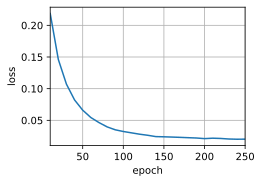

In [6]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 250, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = d2l.Seq2SeqEncoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout
)
decoder = Seq2SeqAttentionDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout
)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [8]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
            f'bleu {d2l.bleu(translation, fra, k=2):.3f}')


go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est malade .,  bleu 0.658
i'm home . => je suis chez moi .,  bleu 1.000


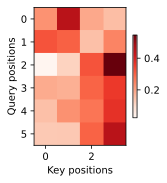

In [9]:
attention_weights = torch.cat([step[0][0][0] for step in dec_attention_weight_seq], 0).reshape((
    1, 1, -1, num_steps))

# 加上⼀个包含序列结束词元
d2l.show_heatmaps(
    attention_weights[:, :, :, :len(engs[-1].split()) + 1].cpu(),
    xlabel='Key positions', ylabel='Query positions')

## 总结
+ 在预测词元时，如果不是所有输⼊词元都是相关的，那么具有Bahdanau注意⼒的循环神经⽹络编码器-解码器会有选择地统计输⼊序列的不同部分。这是通过将上下⽂变量视为加性注意⼒池化的输出来实现的。
+ 在循环神经⽹络编码器-解码器中，Bahdanau注意⼒将上⼀时间步的解码器隐状态视为查询，在所有时间步的编码器隐状态同时视为键和值。

## QA
q: attention在搜索时是在当前句子还是所有文本？ a: 仅在当前句子中搜索